# Projetando um PID

## Modelando o sistema

Este trabalho foi baseado no problema 3.17 do livro *Control Systems* de *Norman S. Nise*, Sétima edição.

![Modelando o vôo do míssil](img/missil.png)

O problema modela o vôo de um míssil, que está sujeito a quatro forças: empuxo (*thrust*), sustentação (*lift*),
arrasto (*drag*) e gravidade. O míssil voa com um ângulo de ataque, $\alpha$, do seu eixo longitudinal, criando sustentação. Para seguir um determinado rumo, o ângulo do corpo da vertical, $\phi$, é controlado rotacionando o motor na cauda. 

A função de transferência relaciona o ângulo do corpo, $\phi$, e sua posição angular, $\delta$, do motor na forma, como mostrado na equação abaixo:

\begin{align}
 \frac{\Phi(s)}{\delta(s)} = \frac{K_a s + K_b}{K_3 s^3 + K_2 s^2 + K_1 s + K_0} \label{eq:plant}
\end{align}

## Entendendo a planta

Desejamos projetar um controlador PID para controlar o míssil, conforme relacionado pelo diagrama de blocos abaixo:

![Diagrama de blocos](img/block-diagram.svg)

Para fins práticos, escolheremos os parâmetros da planta de forma arbitrária.

A resposta ao degrau e impulso da planta são mostrados abaixo: 

In [2]:
import matplotlib.pyplot as plt 
from control import TransferFunction, step_response, bode_plot, impulse_response, series, feedback, rlocus

def plot_step_response(tf, title='Step response'):
    time, output = step_response(tf)
    fig = plt.figure()
    plt.plot(time, output)
    plt.title(title)
    plt.show()

ka, kb, k3, k2, k1, k0 = [100, 5, 2, 50, 10, 100]

missile_tf = TransferFunction([ka, kb], [k3, k2, k1, k0])
sensor_tf = TransferFunction([10], [10, 20])
plot_step_response(missile_tf, title='Plant step response')

<Figure size 640x480 with 1 Axes>

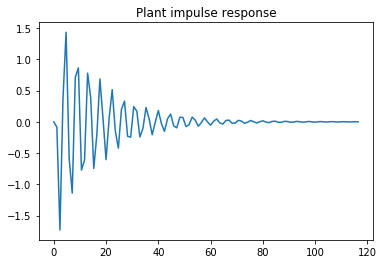

In [3]:
def plot_impulse_response(tf, title='Impulse response'):
    time, output = impulse_response(tf)
    fig = plt.figure()
    plt.plot(time, output)
    plt.title(title)
    plt.show()

plot_impulse_response(missile_tf, title='Plant impulse response')

E também podemos visualizar a resposta em frequência da planta através do diagrama de *Bode*:

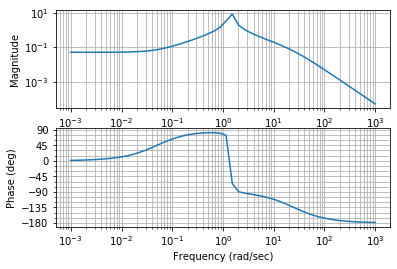

In [4]:
mag, phase, omega = bode_plot(missile_tf)

## Achando o ganho crítico

A fim de aplicarmos as regras 

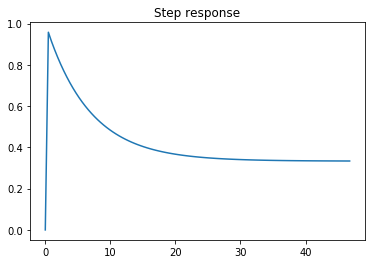

In [12]:
kp = 10
plot_step_response(feedback(kp*missile_tf,1))